# FixMatch


In [1]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from torchvision.transforms.v2 import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm import tqdm

# typing
from typing import Callable

from utils import Data, DataFixMatch, plot_images, plot_transform
from model import ConvNN, display_model

import numpy as np

%load_ext autoreload
%autoreload 2

/Users/ncarmona/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/ncarmona/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

In [2]:
# Set device
if (int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [3]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64 # B
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.001

In [4]:
dataset = Data(batch_size=BATCH_SIZE)

trainLoader = dataset.get_train_loader()
validLoader = dataset.get_valid_loader()
testLoader = dataset.get_test_loader()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
display_model(model=ConvNN(), batch_size=BATCH_SIZE, img_shape=IMG_SHAPE) 

In [11]:
EPOCHS = 10

model = ConvNN()
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA)
criterion = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

train_loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    for (images, labels) in (pbar := tqdm(trainLoader, desc=f"Epoch {epoch: >5}")) :
        # extract mini batch
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        outputs = model.forward(images)
        label_pred = outputs.argmax(dim=1)
        loss = criterion.forward(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        # update metrics
        epoch_loss += loss.item()*images.size(0)/len(trainLoader)

        # print statistics
        pbar.set_postfix(
            {
                "train_loss": f"{loss.item():.2f}",
                "epoch_loss": f"{epoch_loss:.2f}",
                "lr": f"{optimizer.param_groups[0]['lr']:.3f}",
            }
        )
    # scheduler.step()

    # Validation
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0

        for (images_val, label_val) in (pbar := tqdm(validLoader, desc=f"Epoch val {epoch: >1}")):
            images_val, label_val = images_val.to(device), label_val.to(device)
            outputs_val = model.forward(images_val)
            label_pred_val = outputs_val.argmax(dim=1)
            loss_val = criterion.forward(outputs_val, label_val)
            val_epoch_loss += loss_val.item()*images_val.size(0)/len(validLoader)

            val_loss_list.append(loss_val.item())

            pbar.set_postfix(
                {
                    "val_loss": f"{loss_val.item():.2f}",
                    "val_epoch_loss": f"{val_epoch_loss:.2f}",
                    "accuracy": f"{accuracy(label_val.cpu(), label_pred_val.cpu()):.2f}",
                }
            )



Epoch val 9: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s, val_loss=0.71, val_epoch_loss=67.13, accuracy=0.75]


In [12]:
test_image, test_labels = testLoader.__iter__().__next__()
test_image = test_image.to(device)
test_labels = test_labels.to(device)

outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

In [13]:
test_loss = criterion(outputs_test, test_labels).item()

print(f"Test loss: {test_loss:.2f}")

Test loss: 0.90


/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_15346/2830977229.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


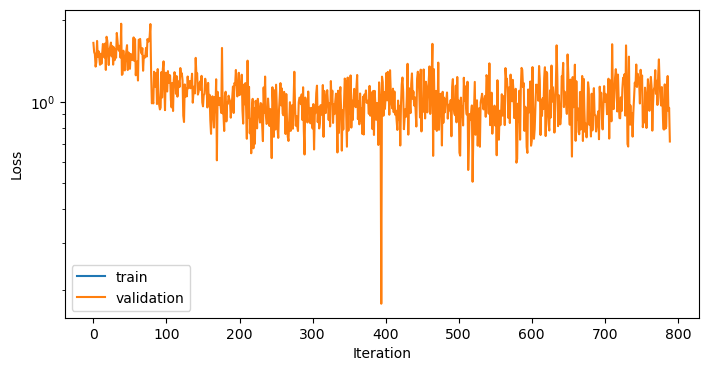

In [14]:
plt.subplots(figsize=(18, 4))

# Plot the loss evolution
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label='train')
plt.plot(np.arange(len(val_loss_list)), val_loss_list, label='validation')
plt.yscale('log')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

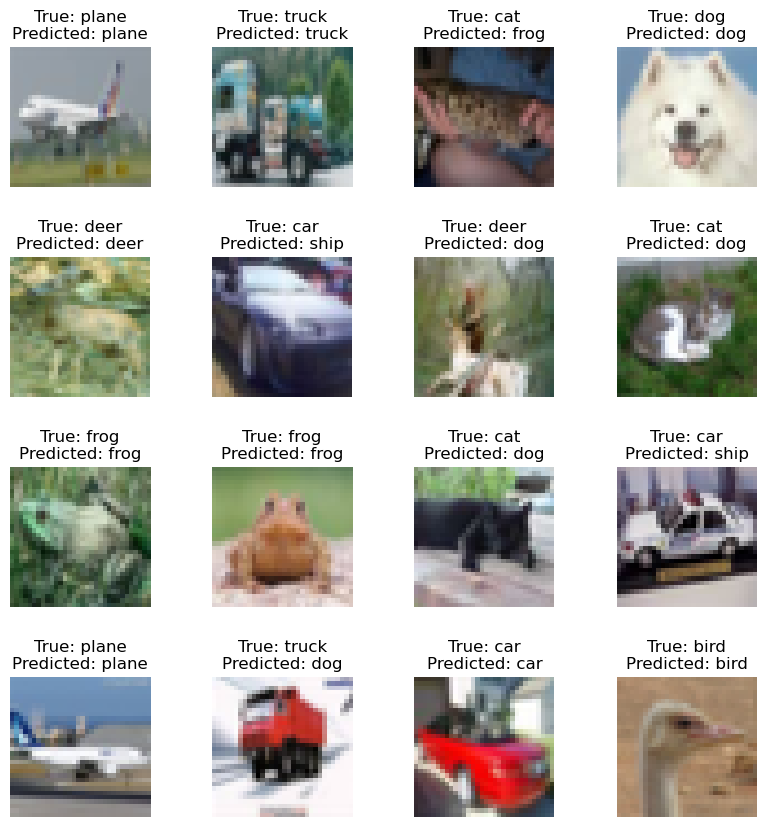

In [15]:
fig1 = plot_images(images=test_image, true_labels=test_labels, predicted_labels=label_pred_test, classes=dataset.classes)

## FixMatch

In [ ]:
EPOCHS = 2

# Model
model = ConvNN().to(device)

# Criterion
supervised_criterion = nn.CrossEntropyLoss().to(device)
unsupervised_criterion = nn.CrossEntropyLoss().to(device)

# Metrics
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

# Optimizer & Scheduler
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
# Transform
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), # 50% chance of flipping
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)), # 12.5% chance of vertical of horizontal translation
)

strong_transform = K.ImageSequential(
    K.auto.AutoAugment("cifar10"),
    # K.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
)

fig2 = plot_transform(test_image, weak_transform, "Weak")
fig3 = plot_transform(test_image, strong_transform, "Strong")

In [ ]:
dataset_fixmatch = DataFixMatch(data=dataset, batch_size=BATCH_SIZE, splits=[1/(1+MU), MU/(1+MU)])

trainloader_sup = dataset_fixmatch.get_trainsup_loader()
trainloader_unsup = dataset_fixmatch.get_trainunsup_loader()

In [ ]:
# Training loop
for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    trainloader_sup_iter = iter(trainloader_sup)

    for batch_idx in (pbar := tqdm(range(len(trainloader_sup)), desc=f"Epoch {epoch: >5}")):
        # extract mini batch
        images_sup, labels_sup = trainloader_sup_iter.__next__()
        images_sup, labels_sup = images_sup.to(device), labels_sup.to(device)
        
        # Supervised part
        with torch.no_grad():
            images_sup_weak = weak_transform(images_sup)
        logits_weak_pred_sup = model.forward(images_sup_weak)
        proba_weak_pred_sup = torch.nn.functional.softmax(logits_weak_pred_sup, dim=1)
        label_weak_pred_sup = proba_weak_pred_sup.argmax(dim=1)
        loss_weak_sup = supervised_criterion.forward(logits_weak_pred_sup, labels_sup)

        # Unsupervised part
        trainloader_unsup_iter = iter(trainloader_unsup)
        loss_strong_unsup = torch.tensor([0.0], device=device)
        for b_batch_idx in range(MU):
            images_unsup, _ = trainloader_unsup_iter.__next__()
            images_unsup = images_unsup.to(device)

            with torch.no_grad():
                image_unsup_weak = weak_transform(images_unsup)
            logits_weak_pred_unsup = model.forward(image_unsup_weak)
            proba_weak_pred_unsup = torch.nn.functional.softmax(logits_weak_pred_unsup, dim=1)
            label_weak_pred_unsup = proba_weak_pred_unsup.argmax(dim=1)
            confidence_mask = proba_weak_pred_unsup.max(dim=1)[0] > TAU

            if len(confidence_mask) != 0:
                continue

            image_unsup_strong = strong_transform(images_unsup)
            logits_strong_pred_unsup = model.forward(image_unsup_strong)
            proba_strong_pred_unsup = torch.nn.functional.softmax(logits_strong_pred_unsup, dim=1)
            label_strong_pred_unsup = proba_strong_pred_unsup.argmax(dim=1)

            if len(confidence_mask) != 0:
                loss_strong_unsup_ = unsupervised_criterion.forward(logits_strong_pred_unsup[confidence_mask], label_weak_pred_unsup[confidence_mask])#*(len(confidence_mask)/images_unsup.size(0))
                loss_strong_unsup  = loss_strong_unsup + loss_strong_unsup_
        # logits under the strong against the label under the weak for confident enough predictions

        # Total loss
        loss = loss_weak_sup + LAMBDA_U*loss_strong_unsup

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        # update metrics
        epoch_loss += loss.item()*(images_sup.size(0) + images_unsup.size(0))/(len(trainset_sup) + LAMBDA_U*len(trainset_unsup))
        # print statistics
        pbar.set_postfix(
            {
                "train_loss_sup": f"{loss_weak_sup.item():.5f}",
                "confident": f"{confidence_mask.sum().item()}",
                "train_loss_unsup": f"{loss_strong_unsup.item():.5f}",
                "train_loss_total": f"{loss.item():.5f}",
                "epoch_loss": f"{epoch_loss:.5f}",
                "lr": f"{optimizer.param_groups[0]['lr']:.3f}",
            }
        )
    # scheduler.step()
    
    # Validation
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for (images_val, label_val) in (pbar := tqdm(validloader, desc=f"Epoch val {epoch: >1}")):
            images_val, label_val = images_val.to(device), label_val.to(device)
            outputs_val = model.forward(images_val)
            label_pred_val = outputs_val.argmax(dim=1)
            loss_val = supervised_criterion.forward(outputs_val, label_val)
            val_epoch_loss += loss_val.item()*images_val.size(0)/len(validloader)
            pbar.set_postfix(
                {
                    "val_loss": f"{loss_val.item():.2f}",
                    "val_epoch_loss": f"{val_epoch_loss:.2f}",
                    "accuracy": f"{accuracy(label_val.cpu(), label_pred_val.cpu()):.2f}",
                }
            )

In [ ]:
test_image, test_labels = testLoader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

In [ ]:
fig1 = plot_images(images=test_image, true_labels=test_labels, predicted_labels=label_pred_test, classes=dataset.classes)